In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csvPath = "data/"
file = "Beijing_housing_price.csv"
df_beijing = pd.DataFrame(pd.read_csv(csvPath + file))
cols=[i for i in df_beijing.columns if i not in ['tradeTime']]
for col in cols:
    df_beijing[col]=pd.to_numeric(df_beijing[col], errors='coerce')
df_beijing['date']=pd.to_datetime(df_beijing['tradeTime'],format='%m/%d/%y')
df_beijing = df_beijing.drop(['constructionTime'], axis=1)


In [2]:
print(df_beijing.head())

          Lng        Lat tradeTime  followers  totalPrice  price  square  \
0  116.475489  40.019520    8/9/16        106       415.0  31680  131.00   
1  116.453917  39.881534   7/28/16        126       575.0  43436  132.38   
2  116.561978  39.877145  12/11/16         48      1030.0  52021  198.00   
3  116.438010  40.076114   9/30/16        138       297.5  22202  134.00   
4  116.428392  39.886229   8/28/16        286       392.0  48396   81.00   

   livingRoom  drawingRoom  kitchen  bathRoom  buildingType  \
0           2            1        1         1             1   
1           2            2        1         2             1   
2           3            2        1         3             4   
3           3            1        1         1             1   
4           2            1        1         1             4   

   renovationCondition  buildingStructure  ladderRatio  elevator  \
0                    3                  6        0.217         1   
1                    4      

# Prediction of Unit Price Using Regression

We are going to compare linear regression and MLP.

## Heatmap

First let's use heatmap to showcase the correlation of other features to house price and identify the feature we should use.

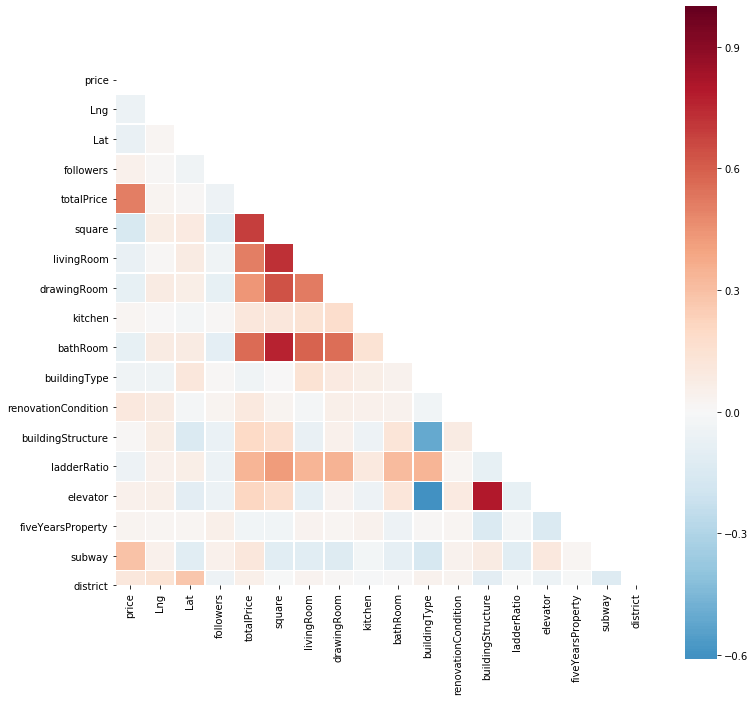

In [3]:
plt.figure(figsize=(12, 12))
corr = df_beijing[
    ['price', 'Lng', 'Lat', 'tradeTime', 'followers', 'totalPrice', 'square', 
     'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'buildingType',
     'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
     'fiveYearsProperty', 'subway', 'district', 'date']].corr() # reorder columns so that price comes first
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap="RdBu_r", center=0,
            square=True, linewidths=.5)


Seems that subway or not and totalPrice has the highiest correlation with price, which is totally understandable that totalPrice is linear related to price, and subway will have huge influence on the housing price. Now let's use 'Lat', 'Lng' and 'subway' to predict the unit price

## Data split

Scaling columns so that MLP can handle the input.

In [4]:
from sklearn.preprocessing import scale
raw_data = np.array(df_beijing[['Lng', 'Lat', 'subway']])
y = scale(np.array(df_beijing['price']))
X = scale(raw_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27) # fix random state


## Linear regression

[-0.06833557 -0.02528569  0.29254585]
0.006466451789354533
train error: 0.9060234914476142
test error:  0.9126705437648716


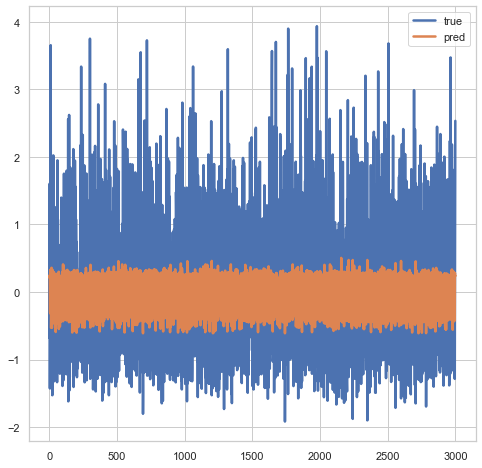

In [5]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print(reg.coef_)
print(reg.intercept_)
reg_pred_train = reg.predict(X_train)
reg_pred_test  = reg.predict(X_test)

from sklearn.metrics import mean_squared_error
print("train error: " + str(mean_squared_error(y_train, reg_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, reg_pred_test)))

sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
grid = np.linspace(1,y_test.shape[0], y_test.shape[0])

sns.lineplot(x = grid, y = y_test, linewidth=2.5, label='true')
sns.lineplot(x = grid, y = reg_pred_test, linewidth=2.5, label='pred')

## MLP

train error: 0.3245657635205486
test error:  0.31935080525626885


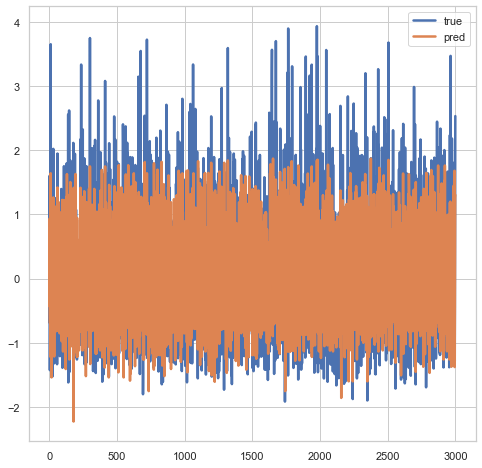

In [7]:
from sklearn.neural_network import MLPRegressor
NN = MLPRegressor(learning_rate='adaptive', learning_rate_init=0.2, early_stopping=True)
NN.fit(X_train, y_train)
NN_pred_train = NN.predict(X_train)
NN_pred_test  = NN.predict(X_test)

print("train error: " + str(mean_squared_error(y_train, NN_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, NN_pred_test)))

sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
grid = np.linspace(1,y_test.shape[0], y_test.shape[0])

sns.lineplot(x = grid, y = y_test, linewidth=2.5, label='true')
sns.lineplot(x = grid, y = NN_pred_test, linewidth=2.5, label='pred')

Wow, MLP seems did a great job here.
But Let's explore other possibilities.

# Prediction of Unit Price as Time Series

First let's plot the trend of unit price, and see if there is a pattern we could use.

## Visualization

[Text(0, 0, '6/2016'),
 Text(0, 0, '7/2016'),
 Text(0, 0, '8/2016'),
 Text(0, 0, '9/2016'),
 Text(0, 0, '10/2016'),
 Text(0, 0, '11/2016'),
 Text(0, 0, '12/2016'),
 Text(0, 0, '1/2017'),
 Text(0, 0, '2/2017'),
 Text(0, 0, '3/2017'),
 Text(0, 0, '4/2017'),
 Text(0, 0, '5/2017'),
 Text(0, 0, '6/2017'),
 Text(0, 0, '7/2017'),
 Text(0, 0, '9/2017'),
 Text(0, 0, '10/2017')]

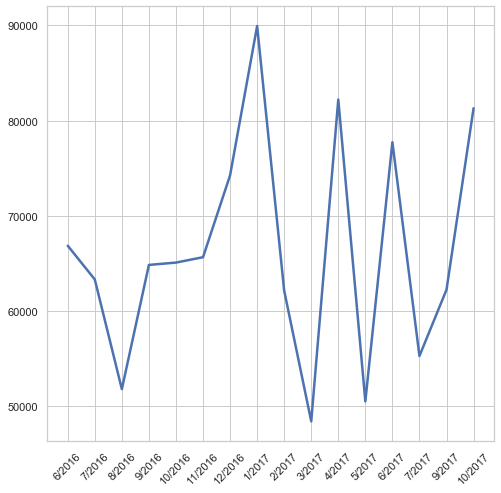

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
years  = sorted(df_beijing['date'].dt.year.unique())
months = sorted(df_beijing['date'].dt.month.unique())
x_month = []
y_month = []
for i in years:
    for j in months:
        this_x = str(j)+'/'+str(i)
        temp_df = df_beijing[(df_beijing['date'].dt.year == i) & (df_beijing['date'].dt.month == j)].mean()
        this_y = temp_df['price']
        if not np.isnan(this_y):
            x_month.append(this_x)
            y_month.append(this_y)

ax = sns.lineplot(x = x_month, y = y_month, linewidth=2.5)
ax.set_xticklabels(x_month, rotation=45)

Oops, no obvious trend exits if group the sales data by month, how about by week?

[Text(0, 0, '06/15/2016'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '07/06/2016'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '07/27/2016'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '08/17/2016'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '09/07/2016'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '09/28/2016'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '10/19/2016'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '11/09/2016'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '11/30/2016'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '12/21/2016'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '01/11/2017'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '02/08/2017'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '03/01/2017'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '03/22/2017'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '04/19/2017'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '07/12/2017'),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '08/30/2017'

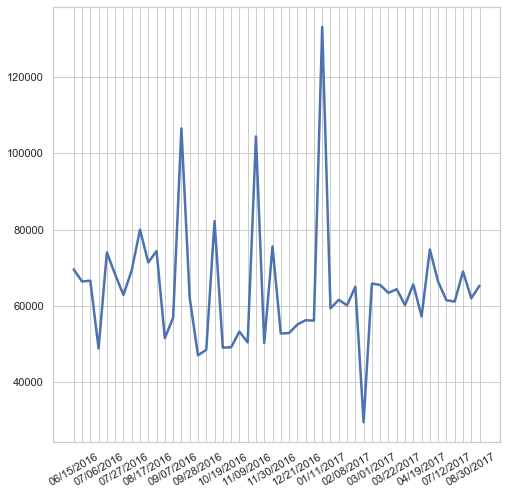

In [9]:
min_day = df_beijing['date'].min()
max_day = df_beijing['date'].max()
a = pd.date_range(start = min_day, end = max_day, freq='7D')
x_week = []
y_week = []
for i in range(a.shape[0]):
    if i + 1 < a.shape[0]:
        temp_df = df_beijing[(df_beijing['date'] >= a[i]) & (df_beijing['date']< a[i+1])].mean()
        this_y = temp_df['price']
        if not np.isnan(this_y):
            x_week.append(a[i].strftime('%m/%d/%Y'))
            y_week.append(this_y)

from pandas.plotting import register_matplotlib_converters
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
ax = sns.lineplot(x = x_week, y = y_week, linewidth=2.5)
labels = ax.get_xticklabels() # get x labels
for i,l in enumerate(labels):
    if(i%3 == 0): labels[i] = x_week[i]
ax.set_xticklabels(labels, rotation=30) # set new labels

now we can see that the housing price is going up by time, let's make sure this trend exist by plotting the data point by day.

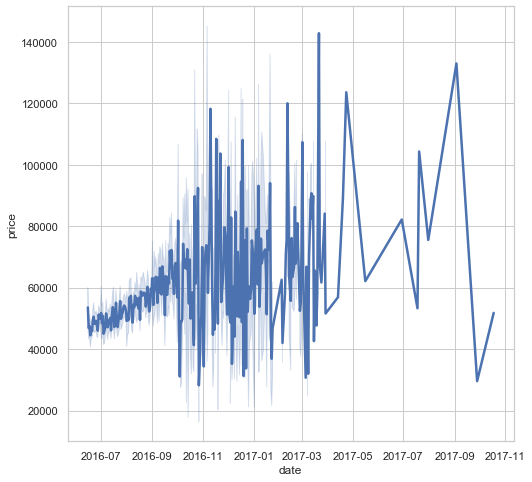

In [10]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
ax = sns.lineplot(x = 'date', y = 'price', data = df_beijing, estimator="mean", err_style = 'band', linewidth=2.5)

Bingo! We can see it clearly that the daily housing price going up at 2016, but the trend disappears after 2017, possibly because we don't have enough data. 

Let's see the qualify of unit price prediction if we treat it as a time series. We will discard the data after March 2017 because we don't have enough data. For comparison, we are going to use linear regression and MLP, both with window size of 7 days. For training and testing, we are going to use the first 70% of valid data as training and the rest as testing.

## Linear Regression

In [11]:
from sklearn.preprocessing import scale

df_ts = df_beijing[df_beijing['date'] < '2017-04-01'][['date','price']]
min_day = df_ts['date'].min()
max_day = df_ts['date'].max()
a = pd.date_range(start = min_day, end = max_day, freq='D')
raw_price = np.zeros(a.shape)

for i in range(a.shape[0]):
    temp = df_ts[df_ts['date'] == a[i]]
    if not temp.empty:
        raw_price[i] = temp['price'].mean()
    else:
        raw_price[i] = raw_price[0:i].mean()

scale_price = scale(raw_price)
ts_X = []
ts_y = []
for i in range(scale_price.shape[0]):
    if i+7 <= scale_price.shape[0]-1:
        ts_X.append(scale_price[i:i+7])
        ts_y.append(scale_price[i+7])

ts_X = np.array(ts_X)
ts_y = np.array(ts_y)
ts_training_X = ts_X[:int(0.7*ts_y.shape[0]),:]
ts_testing_X  = ts_X[int(0.7*ts_y.shape[0]):,:]
ts_training_y = ts_y[:int(0.7*ts_y.shape[0])]
ts_testing_y  = ts_y[int(0.7*ts_y.shape[0]):]

## Multilayer Perceptron

train error: 0.7557373037787318
test error:  1.4416422238690618


Text(0.5, 1.0, 'LR on Testing set')

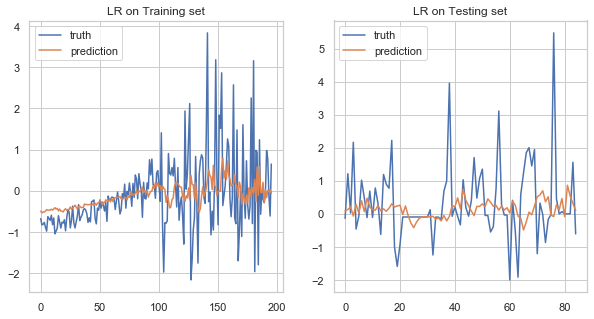

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(ts_training_X, ts_training_y)
reg_pred_train = reg.predict(ts_training_X)
reg_pred_test  = reg.predict(ts_testing_X)
print("train error: " + str(mean_squared_error(ts_training_y, reg_pred_train)))
print("test error:  " + str(mean_squared_error(ts_testing_y,  reg_pred_test)))

f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(list(range(len(ts_training_y))), ts_training_y,     ax=axes[0], label='truth')
sns.lineplot(list(range(len(ts_training_y))), reg_pred_train, ax=axes[0], label='prediction') 
axes[0].set_title('LR on Training set')
    
sns.lineplot(list(range(len(ts_testing_y))), ts_testing_y,     ax=axes[1], label='truth')
sns.lineplot(list(range(len(ts_testing_y))), reg_pred_test, ax=axes[1], label='prediction')
axes[1].set_title('LR on Testing set')
    


train error: 0.8389910190282119
test error:  1.3514201836292594


Text(0.5, 1.0, 'MLP on Testing set')

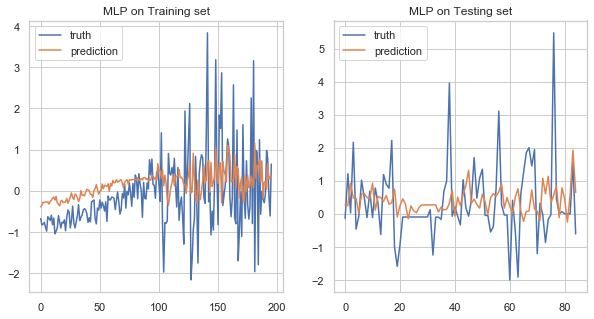

In [13]:
from sklearn.neural_network import MLPRegressor
NN = MLPRegressor(learning_rate='adaptive', learning_rate_init=0.1, early_stopping=True, random_state = 8)
NN.fit(ts_training_X, ts_training_y)
NN_pred_train = NN.predict(ts_training_X)
NN_pred_test  = NN.predict(ts_testing_X)

print("train error: " + str(mean_squared_error(ts_training_y, NN_pred_train)))
print("test error:  " + str(mean_squared_error(ts_testing_y,  NN_pred_test)))

f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(list(range(len(ts_training_y))), ts_training_y, ax=axes[0], label='truth')
sns.lineplot(list(range(len(ts_training_y))), NN_pred_train, ax=axes[0], label='prediction') 
axes[0].set_title('MLP on Training set')
    
sns.lineplot(list(range(len(ts_testing_y))), ts_testing_y, ax=axes[1], label='truth')
sns.lineplot(list(range(len(ts_testing_y))), NN_pred_test, ax=axes[1], label='prediction')
axes[1].set_title('MLP on Testing set')
    



Note that if we change the random state, MLP might perform slightly worse than linear regression. So I would say there is significant difference between this 2 models.

Maybe it's not a good idea to perform housing price by treating it as time series, after all, there is little relation between current housing price and previous housing price.

# Prediction of Unit Price Using Classifier

We can also predict the housing price using classifier. First let's validate this idea.

## Clustering based on geographic info

Now let's look at the geographic distribution of housing price, as we all know, location, location, location!!!

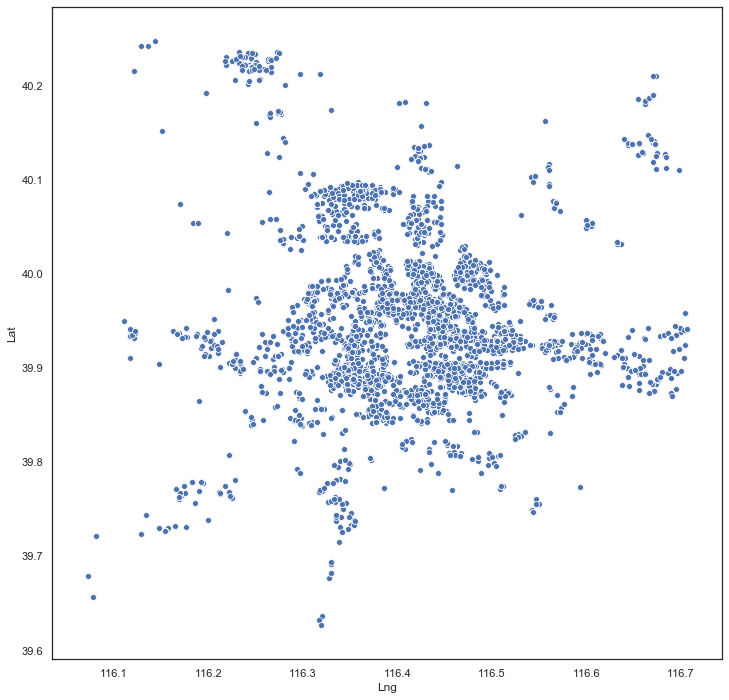

In [14]:
sns.set(style="white")
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x='Lng', y='Lat', data=df_beijing)

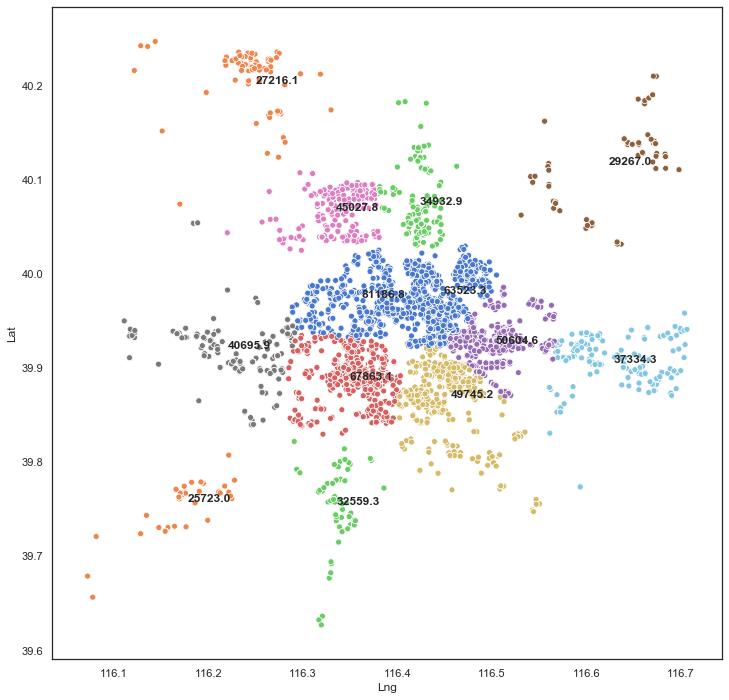

In [15]:
from sklearn.cluster import KMeans
N_clusters = 13
KMC_beijing = KMeans(n_clusters = N_clusters)
KMC_beijing.fit(df_beijing[['Lng','Lat']])
KMC_beijing_pred = KMC_beijing.predict(df_beijing[['Lng','Lat']])
df_beijing['cluster'] = KMC_beijing_pred  

plt.figure(figsize=(12, 12))

ax = sns.scatterplot(x='Lng', y='Lat', hue='cluster', 
                     palette=sns.color_palette("muted", n_colors=N_clusters), 
                     legend = False,
                     data=df_beijing)
for i in df_beijing['cluster'].unique():
    df_average = df_beijing[df_beijing['cluster'] == i].mean()
    ax.text(df_average['Lng'], df_average['Lat'], str(df_average['price'].round(1)), 
            horizontalalignment='left', size='medium', weight='semibold')

This is very interesting, because (1) the average prices of clusters are different from the adjacent ones, meaning that it's possible to predict the housing price using classifier too; and (2) some, or most of the clusters actually correspond to the administrative divisions of Beijing, which is shown as following: See the region in red box as that is the part of the most data fall into.

![title](pic/Beijing_copy.png)


## Joint distribution 

Now let's see the influence of other features on the housing price, here we are going to focus on livingRoom and bathRoom, as they seem likely to influence the housing price. Note that livingRoom here means the bedroom.

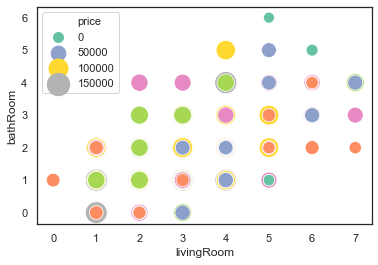

In [16]:
sns.scatterplot(x='livingRoom', y='bathRoom', hue="price", size="price", sizes=(100, 500), 
                data = df_beijing, palette="Set2")

It makes some sense that the house with one living room and one bathroom will be more expensive than that with 3 livingRooms and 1 bedroom, as we know that studio will be more expensive than 2b2b. 

Combining with the clustering result, it seems possible to predict the housing price using classifers. The general idea to use a classifier to predict the housing price is: first discretize the price into serveral intervals, then train some classifier to classify the data into some class. For each data point belonging to some class, use the interval info(such as mean of the interval, mean of data in the interval. etc.) as the predicted price. The advantage is, we will solve 2 subproblem, discretization and classification instead of the regression problem, which gives us more freedom to design our approach, such as using ensemble method. The disadvantage is that both of the subproblems could lead to some error which will event


We will use random forest to substitute linear regression here.

## Data split

In [83]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import KBinsDiscretizer
raw_data = np.array(df_beijing[['Lng', 'Lat', 'subway', 'livingRoom', 'bathRoom']])
X = scale(raw_data)
sy = scale(df_beijing['price'])

discretizer = KBinsDiscretizer(n_bins=20, encode='ordinal')
y = discretizer.fit_transform(sy.reshape(-1, 1))
print('Discretize error: ' + str(mean_squared_error(discretizer.inverse_transform(y), sy)))

np.random.seed(42)
index = np.random.choice(X.shape[0], int(0.7*X.shape[0]), replace=False)
X_train = X[index,:]
y_train = y[index,:]
rest_index = list(set(list(range(X.shape[0]))) - set(index))
X_test = X[rest_index,:]
y_test = y[rest_index,:]


Discretize error: 0.03800062542309332


In [84]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(X_train, y_train.ravel())


clf_pred_train = discretizer.inverse_transform(clf.predict(X_train).reshape(-1, 1))
clf_pred_test  = discretizer.inverse_transform(clf.predict(X_test).reshape(-1, 1))


print("train error: " + str(mean_squared_error(clf_pred_train.ravel(), sy[index])))
print("test error:  " + str(mean_squared_error(clf_pred_test.ravel(),  sy[rest_index])))


train error: 0.08696467881749029
test error:  2.227263265241666


In [90]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(learning_rate='adaptive', learning_rate_init=0.01, early_stopping=True)
MLP.fit(X_train, y_train.ravel())
MLP_pred_train = discretizer.inverse_transform(MLP.predict(X_train).reshape(-1, 1))
MLP_pred_test  = discretizer.inverse_transform(MLP.predict(X_test).reshape(-1, 1))

print("train error: " + str(mean_squared_error(MLP_pred_train.ravel(), sy[index])))
print("test error:  " + str(mean_squared_error(MLP_pred_test.ravel(),  sy[rest_index])))



train error: 0.551916926071928
test error:  2.6203623597871197


Seems that classifier cannot compete with regression, after all, there exist the Discretize error which will confine the performance of classifier.